**Adapted in entirety from GPFlow's [example notebook](https://nbviewer.jupyter.org/github/GPflow/GPflow/blob/develop-1.0/doc/source/notebooks/basics/regression.ipynb)**


# Basic (Gaussian likelihood) GP regression model


This notebook shows the different steps for creating and using a standard GP regression model, including:
  - reading and formatting data
  - choosing a kernel function
  - choosing a mean function (optional)
  - creating the model
  - viewing, getting, and setting model parameters
  - optimising the model parameters
  - making predictions
  
We focus here on the implementation of the models in GPflow; for more intuition on these models, see [A Practical Guide to Gaussian Processes](https://drafts.distill.pub/gp/).
 

In [1]:
using GPJ;
using DelimitedFiles;
using PyPlot;

`X` and `Y` denote the input and output values. **NOTE:** `X` and `Y` must be two-dimensional NumPy arrays, $N \times 1$ or $N \times D$, where $D$ is the number of input dimensions/features, with the same number of rows as $N$ (one for each data point):

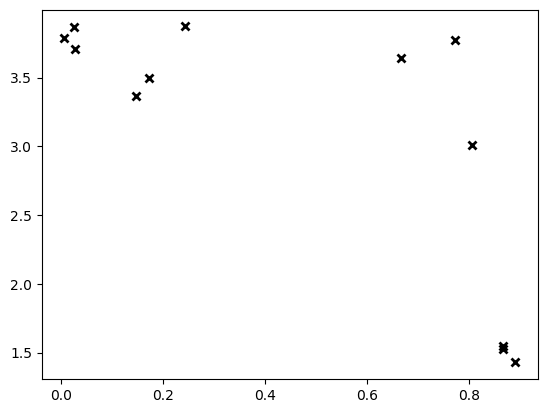

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa3da095810>

In [2]:
data = readdlm(open("./data/regression_1D.csv"), ',')
X = data[:, 1]
Y = data[:, 2]

X = reshape(X, :, 1)
Y = reshape(Y, :, 1)

plot(X, Y, "kx", mew=2)

We will consider the following probabilistic model:
$$ Y_i = f(X_i) + \varepsilon_i , $$
where $f \sim \mathcal{GP}(\mu(.), k(., .'))$, and $\varepsilon \sim \mathcal{N}(0, \tau^2 I)$.

## Choose a kernel 
Several kernels (covariance functions) are implemented in GPflow. You can easily combine them to create new ones (see [Manipulating kernels](../advanced/kernels.ipynb)). You can also implement new covariance functions, as shown in the [Kernel design](../tailor/kernel_design.ipynb) notebook. Here, we will use a simple one:

In [3]:
k = gpflow.kernels.Matern52(1);







2020-01-08 21:17:14.311502: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-01-08 21:17:14.316209: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2494270000 Hz
2020-01-08 21:17:14.316654: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7350a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-01-08 21:17:14.316670: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-01-08 21:17:14.318135: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/sharan/.mujoco/mjpro150/bin
2020-01-08 21:17:14.318152: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ER

The `input_dim` parameter is the dimension of the input space. It typically corresponds to the number of columns in `X`  (see [Manipulating kernels](../advanced/kernels.ipynb) for more information on kernels defined on subspaces). You can get a summary of the kernel, either by using `print(k)` (plain text) or as follows:

In [4]:
k.o.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
Matern52/lengthscales,Parameter,None,+ve,True,(),True,1.0
Matern52/variance,Parameter,None,+ve,True,(),True,1.0


┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = show(::IOContext{Base.GenericIOBuffer{Array{UInt8,1}}}, ::MIME{Symbol("text/html")}, ::PyCall.PyObject) at PyCall.jl:895
└ @ PyCall /home/sharan/.julia/packages/PyCall/ttONZ/src/PyCall.jl:895


The Matern 5/2 kernel has two parameters: `lengthscales`, which encodes the "wiggliness" of the GP, and `variance`, which tunes the amplitude. They are both set to 1.0 as the default value. For more details on the meaning of the other columns, see [Manipulating kernels](../advanced/kernels.ipynb).

## Choose a mean function (optional)
It is common to choose $\mu = 0$, which is the GPflow default. 

However, if there is a clear pattern (such as a mean value of `Y` that is far away from 0, or a linear trend in the data), mean functions can  be beneficial. Some simple ones are provided in the `gpflow.mean_functions` module.

Here's how to define a linear mean function:

`meanf = gpflow.mean_functions.Linear()`

## Construct a model
A GPflow model is created by instantiating one of the GPflow model classes, in this case GPR. We'll make a kernel `k` and instantiate a GPR object using the generated data and the kernel. We'll also set the variance of the likelihood to a sensible initial guess. 

In [5]:
m = gpflow.models.GPR(X, Y, k, mean_function=nothing);

You can get a summary of the model, either by using `print(m)` (plain text) or as follows:

In [6]:
m.o.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


The first two lines correspond to the kernel parameters, and the third one gives the likelihood parameter (the noise variance $\tau^2$ in our model).

You can access those values and manually set them to sensible initial guesses. For example:


In [7]:
m.o.likelihood.variance = 0.01
m.o.kern.lengthscales = 0.3

0.3

## Optimise the model parameters
To obtain meaningful predictions, you need to tune the model parameters (that is, the parameters of the kernel, the likelihood, and the mean function if applicable) to the data at hand. 

There are several optimisers available in GPflow. Here we use the `ScipyOptimizer`, which by default implements the L-BFGS-B algorithm. You can select other algorithms by using the `method=` keyword argument of `ScipyOptimizer`; see [the SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for details of available options.

In [8]:
opt = gpflow.train.ScipyOptimizer();
minimize!(opt, m);
m.o.as_pandas_table()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 9.733150
  Number of iterations: 17
  Number of functions evaluations: 19


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 9.733150
  Number of iterations: 17
  Number of functions evaluations: 19


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.21241640661424005
GPR/kern/variance,Parameter,None,+ve,True,(),True,7.965816047733742
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.005759398770590029


Notice how the value column has changed.

The local optimum found by Maximum Likelihood might not be the one you want (for example, it might be overfitting or oversmooth). This depends on the initial values of the hyperparameters, and is specific to each dataset. As an alternative to Maximum Likelihood, [Markov Chain Monte Carlo (MCMC)](../advanced/mcmc.ipynb) is also available.

## Make predictions

We can now use the model to make some predictions at the new points `Xnew`. You might be interested in predicting two different quantities: the latent function values `f(Xnew)` (the denoised signal), or the values of new observations `y(Xnew)` (signal + noise). Because we are dealing with Gaussian probabilistic models, the predictions typically produce a mean and variance as output. Alternatively, you can obtain samples of `f(Xnew)` or the log density of the new data points `(Xnew, Ynew)`.

GPflow models have several prediction methods:

 - `m.predict_f` returns the mean and variance of $f$ at the points `Xnew`. 

 - `m.predict_f_full_cov` additionally returns the full covariance matrix of $f$ at the points `Xnew`.

 - `m.predict_f_samples` returns samples of the latent function.

 - `m.predict_y` returns the mean and variance of a new data point (that is, it includes the noise variance).

 - `m.predict_density` returns the log density of the observations `Ynew` at `Xnew`.
 
We use `predict_f` and `predict_f_samples` to plot 95% confidence intervals and samples from the posterior distribution. 

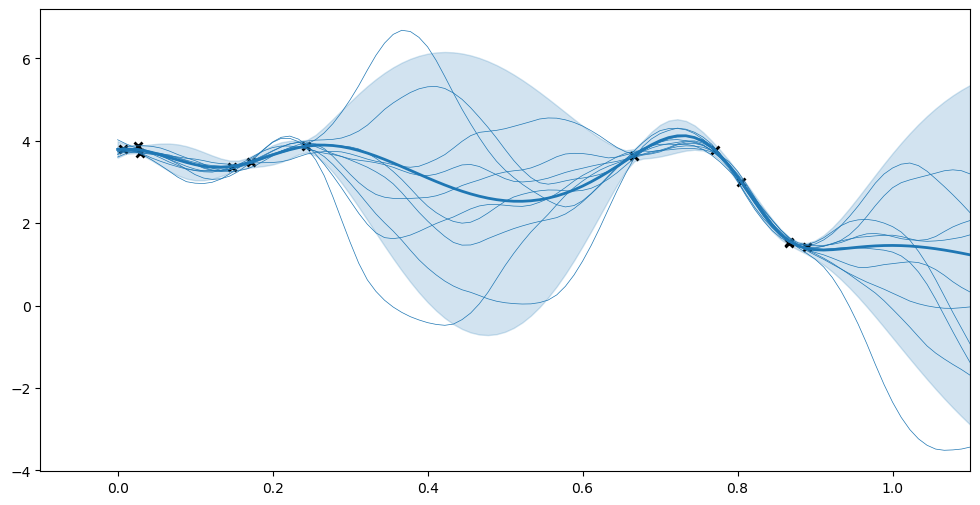

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().



Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().



In [9]:
## generate test points for prediction
xx = reshape(range(0,stop=1.1,length=100), 100, 1);  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = predict_f(m, xx);

## generate 10 samples from posterior
samples = predict_f_samples(m, xx, 10);  # shape (10, 100, 1)

## plot
figure(figsize=(12, 6));
plot(X, Y, "kx", mew=2);
plot(xx, mean, "C0", lw=2);
fill_between(xx[:,1],
                 mean[:,1] - 1.96 * sqrt.(var[:,1]),
                 mean[:,1] + 1.96 * sqrt.(var[:,1]),
                 color="C0", alpha=0.2);
plot(xx, samples[:, :, 1]', "C0", linewidth=.5);
xlim(-0.1, 1.1);

## GP regression in higher dimensions
Very little changes when the input space has more than one dimension. `X` is a NumPy array with one column for each dimension. The kernel can be set with `input_dim` equal to the number of columns of `X`. It is generally recommended that you set the `ARD` (Automatic Relevance Determination) parameter to `True` to enable you to tune a different lengthscale for each dimension.

## Further reading

  - [Stochastic Variational Inference for scalability with SVGP](../advanced/gps_for_big_data.ipynb) for cases where there are a large number of observations.
  - [Ordinal regression](../advanced/ordinal_regression.ipynb) if the data is ordinal.
  - [Multi-output models and coregionalisation](../advanced/coregionalisation.ipynb) if `Y` is multidimensional.